In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from modules import dataset, vqvae, tools, pixelcnn

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Train the VQVAE model
Load the data from dataset.

In [2]:
data_train, data_validate, data_test = dataset.load_data()
print(len(data_train))
print(len(data_validate))
print(len(data_test))

9664
1120
544


Create image generator to pass to the vqvae model for training.

In [3]:
data_gen = dataset.data_generator(train_data = data_train, batch_size = 8)
validate_gen = dataset.validate_generator(validate_data = data_validate, batch_size = 8)

In [4]:
img= next(data_gen)
print(img.shape)
img = next(validate_gen)
print(img.shape)
print(len(data_train))
print(len(data_validate))

(8, 256, 256, 1)
(8, 256, 256, 1)
9664
1120


In [5]:
steps_per_epoch = len(data_train)/8
valiation_steps = len(data_validate)/8
print(steps_per_epoch)
print(valiation_steps)

1208.0
140.0


Train the VQVAE model.

In [6]:
vqvae_trainer = vqvae.VQVAE(latent_dim=256, num_embeddings=256)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
history = vqvae_trainer.fit(data_gen, epochs = 20, validation_data = validate_gen, batch_size = 8, 
                    validation_steps = valiation_steps, validation_batch_size = 8, steps_per_epoch = steps_per_epoch)

Epoch 1/20
1208/1208 [==============================] - 62s 50ms/step - total_loss: 0.0470 - reconstruction_loss: 0.0039 - vq_loss: 0.0431 - val_total_loss: 0.0051 - val_reconstruction_loss: 0.0019 - val_vq_loss: 0.0032
Epoch 2/20
1208/1208 [==============================] - 57s 47ms/step - total_loss: 0.0043 - reconstruction_loss: 0.0016 - vq_loss: 0.0027 - val_total_loss: 0.0039 - val_reconstruction_loss: 0.0015 - val_vq_loss: 0.0025
Epoch 3/20
1208/1208 [==============================] - 57s 47ms/step - total_loss: 0.0036 - reconstruction_loss: 0.0013 - vq_loss: 0.0023 - val_total_loss: 0.0035 - val_reconstruction_loss: 0.0013 - val_vq_loss: 0.0022
Epoch 4/20
1208/1208 [==============================] - 57s 47ms/step - total_loss: 0.0033 - reconstruction_loss: 0.0012 - vq_loss: 0.0020 - val_total_loss: 0.0033 - val_reconstruction_loss: 0.0013 - val_vq_loss: 0.0020
Epoch 5/20
1208/1208 [==============================] - 57s 47ms/step - total_loss: 0.0031 - reconstruction_loss: 0.0012

Plot some results of the model (original image vs. reconstructed image outputs from the model) 

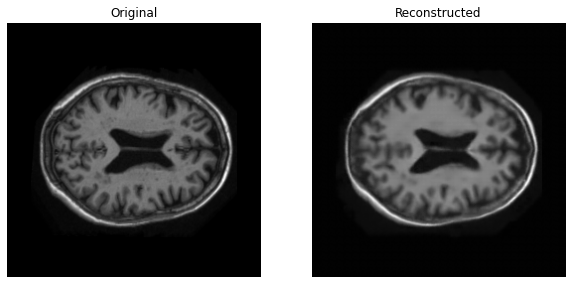

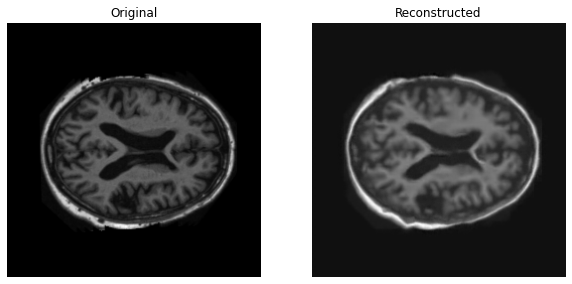

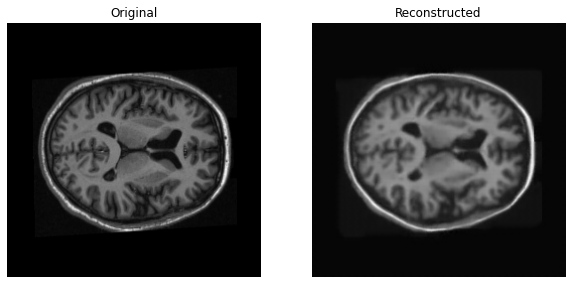

In [7]:
img_count = 3
tools.plot_images(img_count, data_test, vqvae_trainer)

Calculate the structured similarity between the original image and the reconstructed image.

In [8]:
print(tools.mean_ssim(data_test, vqvae_trainer))

0.9886685508478235


# Preprocess the data to be loaded into pixelcnn.
For each image, pass it to the trained vqvae encoder and map the output from the encoder to the closest latent embedding vector in the latent space. Since the dataset is large, it is impossible to load all the preprocessed image into the memory. Instead, I used a generator to load the images in batch size of 32.

In [7]:
train_gen = dataset.train_codebook_generator(data_train, vqvae_trainer, batch_size = 32)

data = next(train_gen)
print(data[0].shape, data[1].shape)

(32, 32, 32, 256) (32, 32, 32, 256)


In [8]:
valid_gen = dataset.validate_codebook_generator(data_validate, vqvae_trainer, batch_size = 32)

data = next(valid_gen)
print(data[0].shape, data[1].shape)

(32, 32, 32, 256) (32, 32, 32, 256)


In [9]:
input_shape = tools.get_cnn_shape(vqvae_trainer.encoder, data_test)[1:-1]
num_embeddings = vqvae_trainer.vq_layer.num_embeddings#256
num_residual_blocks = 7
num_pixelcnn_layers = 2
print(input_shape, num_embeddings)

(32, 32) 256


In [10]:
steps_per_epoch = len(data_train)/32
valiation_steps = len(data_validate)/32
print(steps_per_epoch)
print(valiation_steps)

302.0
35.0


In [11]:
from modules import pixelcnn2

In [20]:
pixel_cnn = pixelcnn2.PixelCNN(num_residual_blocks, num_pixelcnn_layers, num_embeddings,7)
pixel_cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003),loss = tf.losses.CategoricalCrossentropy(from_logits = True), metrics=['accuracy'])
pixel_cnn.fit(x = train_gen, epochs = 600, validation_data = valid_gen, batch_size = 32, 
                    validation_steps = valiation_steps, validation_batch_size = 32, steps_per_epoch = steps_per_epoch)

Epoch 1/600
302/302 [==============================] - 36s 115ms/step - loss: 2.4713 - accuracy: 0.5280 - val_loss: 3.6777 - val_accuracy: 0.4912
Epoch 2/600
302/302 [==============================] - 34s 114ms/step - loss: 1.9306 - accuracy: 0.5696 - val_loss: 1.9288 - val_accuracy: 0.5705
Epoch 3/600
302/302 [==============================] - 34s 114ms/step - loss: 1.7522 - accuracy: 0.5865 - val_loss: 1.7231 - val_accuracy: 0.5885
Epoch 4/600
302/302 [==============================] - 34s 114ms/step - loss: 1.6417 - accuracy: 0.5985 - val_loss: 1.6556 - val_accuracy: 0.5950
Epoch 5/600
302/302 [==============================] - 34s 114ms/step - loss: 1.5667 - accuracy: 0.6078 - val_loss: 1.6050 - val_accuracy: 0.5997
Epoch 6/600
302/302 [==============================] - 34s 114ms/step - loss: 1.5143 - accuracy: 0.6149 - val_loss: 1.5753 - val_accuracy: 0.6035
Epoch 7/600
302/302 [==============================] - 34s 114ms/step - loss: 1.4762 - accuracy: 0.6202 - val_loss: 1.5581 -

302/302 [==============================] - 34s 114ms/step - loss: 1.1984 - accuracy: 0.6687 - val_loss: 1.6076 - val_accuracy: 0.6069
Epoch 57/600
302/302 [==============================] - 34s 114ms/step - loss: 1.1962 - accuracy: 0.6692 - val_loss: 1.6158 - val_accuracy: 0.6065
Epoch 58/600
302/302 [==============================] - 35s 114ms/step - loss: 1.1942 - accuracy: 0.6697 - val_loss: 1.6179 - val_accuracy: 0.6063
Epoch 59/600
302/302 [==============================] - 34s 114ms/step - loss: 1.1925 - accuracy: 0.6702 - val_loss: 1.6174 - val_accuracy: 0.6063
Epoch 60/600
302/302 [==============================] - 34s 114ms/step - loss: 1.1907 - accuracy: 0.6705 - val_loss: 1.6211 - val_accuracy: 0.6061
Epoch 61/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1891 - accuracy: 0.6709 - val_loss: 1.6196 - val_accuracy: 0.6067
Epoch 62/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1874 - accuracy: 0.6713 - val_loss: 1.6219 - val_a

Epoch 112/600
302/302 [==============================] - 34s 114ms/step - loss: 1.1437 - accuracy: 0.6808 - val_loss: 1.6863 - val_accuracy: 0.6044
Epoch 113/600
302/302 [==============================] - 34s 114ms/step - loss: 1.1436 - accuracy: 0.6808 - val_loss: 1.6827 - val_accuracy: 0.6051
Epoch 114/600
302/302 [==============================] - 34s 114ms/step - loss: 1.1425 - accuracy: 0.6810 - val_loss: 1.6850 - val_accuracy: 0.6047
Epoch 115/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1414 - accuracy: 0.6813 - val_loss: 1.6824 - val_accuracy: 0.6051
Epoch 116/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1401 - accuracy: 0.6817 - val_loss: 1.6851 - val_accuracy: 0.6047
Epoch 117/600
302/302 [==============================] - 34s 114ms/step - loss: 1.1394 - accuracy: 0.6819 - val_loss: 1.6899 - val_accuracy: 0.6045
Epoch 118/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1390 - accuracy: 0.6820 - val_

302/302 [==============================] - 34s 113ms/step - loss: 1.1190 - accuracy: 0.6865 - val_loss: 1.7467 - val_accuracy: 0.6021
Epoch 168/600
302/302 [==============================] - 34s 114ms/step - loss: 1.1182 - accuracy: 0.6867 - val_loss: 1.7514 - val_accuracy: 0.6021
Epoch 169/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1176 - accuracy: 0.6869 - val_loss: 1.7504 - val_accuracy: 0.6022
Epoch 170/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1179 - accuracy: 0.6868 - val_loss: 1.7471 - val_accuracy: 0.6033
Epoch 171/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1177 - accuracy: 0.6868 - val_loss: 1.7550 - val_accuracy: 0.5943
Epoch 172/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1172 - accuracy: 0.6871 - val_loss: 1.7579 - val_accuracy: 0.6031
Epoch 173/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1165 - accuracy: 0.6872 - val_loss: 1.7561 -

302/302 [==============================] - 34s 113ms/step - loss: 1.1034 - accuracy: 0.6903 - val_loss: 1.7923 - val_accuracy: 0.5997
Epoch 223/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1042 - accuracy: 0.6900 - val_loss: 1.7969 - val_accuracy: 0.5998
Epoch 224/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1054 - accuracy: 0.6897 - val_loss: 1.7971 - val_accuracy: 0.6002
Epoch 225/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1053 - accuracy: 0.6897 - val_loss: 1.7907 - val_accuracy: 0.6011
Epoch 226/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1043 - accuracy: 0.6900 - val_loss: 1.7960 - val_accuracy: 0.6010
Epoch 227/600
302/302 [==============================] - 34s 113ms/step - loss: 1.1018 - accuracy: 0.6908 - val_loss: 1.7861 - val_accuracy: 0.6012
Epoch 228/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0998 - accuracy: 0.6913 - val_loss: 1.7858 -

302/302 [==============================] - 34s 113ms/step - loss: 1.0847 - accuracy: 0.6954 - val_loss: 1.8296 - val_accuracy: 0.5924
Epoch 278/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0849 - accuracy: 0.6953 - val_loss: 1.8255 - val_accuracy: 0.6017
Epoch 279/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0849 - accuracy: 0.6953 - val_loss: 1.8274 - val_accuracy: 0.6016
Epoch 280/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0850 - accuracy: 0.6953 - val_loss: 1.8286 - val_accuracy: 0.6016
Epoch 281/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0859 - accuracy: 0.6949 - val_loss: 1.8272 - val_accuracy: 0.6017
Epoch 282/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0878 - accuracy: 0.6942 - val_loss: 1.8230 - val_accuracy: 0.6015
Epoch 283/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0863 - accuracy: 0.6948 - val_loss: 1.8188 -

302/302 [==============================] - 34s 113ms/step - loss: 1.0848 - accuracy: 0.6949 - val_loss: 1.8531 - val_accuracy: 0.5992
Epoch 333/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0856 - accuracy: 0.6948 - val_loss: 1.8550 - val_accuracy: 0.5988
Epoch 334/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0840 - accuracy: 0.6952 - val_loss: 1.8543 - val_accuracy: 0.5985
Epoch 335/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0834 - accuracy: 0.6955 - val_loss: 1.8538 - val_accuracy: 0.5986
Epoch 336/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0838 - accuracy: 0.6953 - val_loss: 1.8623 - val_accuracy: 0.5897
Epoch 337/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0844 - accuracy: 0.6951 - val_loss: 1.8603 - val_accuracy: 0.5987
Epoch 338/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0856 - accuracy: 0.6946 - val_loss: 1.8545 -

302/302 [==============================] - 34s 113ms/step - loss: 1.0692 - accuracy: 0.6993 - val_loss: 1.8810 - val_accuracy: 0.5993
Epoch 388/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0681 - accuracy: 0.6997 - val_loss: 1.8918 - val_accuracy: 0.5991
Epoch 389/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0676 - accuracy: 0.6999 - val_loss: 1.8901 - val_accuracy: 0.5993
Epoch 390/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0678 - accuracy: 0.6998 - val_loss: 1.8880 - val_accuracy: 0.5996
Epoch 391/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0677 - accuracy: 0.6999 - val_loss: 1.8893 - val_accuracy: 0.5992
Epoch 392/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0685 - accuracy: 0.6995 - val_loss: 1.8819 - val_accuracy: 0.5996
Epoch 393/600
302/302 [==============================] - 35s 115ms/step - loss: 1.0687 - accuracy: 0.6995 - val_loss: 1.8787 -

302/302 [==============================] - 34s 114ms/step - loss: 1.0625 - accuracy: 0.7012 - val_loss: 1.9120 - val_accuracy: 0.6000
Epoch 443/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0622 - accuracy: 0.7013 - val_loss: 1.9121 - val_accuracy: 0.5999
Epoch 444/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0625 - accuracy: 0.7011 - val_loss: 1.9134 - val_accuracy: 0.5999
Epoch 445/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0634 - accuracy: 0.7007 - val_loss: 1.9229 - val_accuracy: 0.5999
Epoch 446/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0635 - accuracy: 0.7008 - val_loss: 1.9215 - val_accuracy: 0.5999
Epoch 447/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0633 - accuracy: 0.7008 - val_loss: 1.9235 - val_accuracy: 0.5994
Epoch 448/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0639 - accuracy: 0.7007 - val_loss: 1.9169 -

302/302 [==============================] - 34s 113ms/step - loss: 1.0584 - accuracy: 0.7022 - val_loss: 1.9405 - val_accuracy: 0.5994
Epoch 498/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0580 - accuracy: 0.7023 - val_loss: 1.9419 - val_accuracy: 0.5994
Epoch 499/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0584 - accuracy: 0.7021 - val_loss: 1.9470 - val_accuracy: 0.5992
Epoch 500/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0595 - accuracy: 0.7017 - val_loss: 1.9479 - val_accuracy: 0.5991
Epoch 501/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0598 - accuracy: 0.7017 - val_loss: 1.9401 - val_accuracy: 0.5993
Epoch 502/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0591 - accuracy: 0.7019 - val_loss: 1.9368 - val_accuracy: 0.5992
Epoch 503/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0593 - accuracy: 0.7018 - val_loss: 1.9415 -

302/302 [==============================] - 34s 113ms/step - loss: 1.0544 - accuracy: 0.7031 - val_loss: 1.9643 - val_accuracy: 0.5983
Epoch 553/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0544 - accuracy: 0.7031 - val_loss: 1.9709 - val_accuracy: 0.5984
Epoch 554/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0548 - accuracy: 0.7029 - val_loss: 1.9678 - val_accuracy: 0.5982
Epoch 555/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0537 - accuracy: 0.7033 - val_loss: 1.9728 - val_accuracy: 0.5983
Epoch 556/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0530 - accuracy: 0.7036 - val_loss: 1.9764 - val_accuracy: 0.5982
Epoch 557/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0521 - accuracy: 0.7039 - val_loss: 1.9735 - val_accuracy: 0.5981
Epoch 558/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0531 - accuracy: 0.7035 - val_loss: 1.9782 -

In [23]:
pixel_cnn.save("pixelcnn.h")
#vqvae_trainer = tf.keras.models.load_model("pixelcnn.h")

INFO:tensorflow:Assets written to: pixelcnn.h\assets


INFO:tensorflow:Assets written to: pixelcnn.h\assets


In [24]:
import tensorflow_probability as tfp

In [25]:
#get the output shape of the encoder
train_gen_1 = dataset.train_codebook_generator(data_train, vqvae_trainer, batch_size = 1)
data = next(train_gen_1)
print(data[0].shape)
out = pixel_cnn.predict(data[0])

print(out.shape)
print(out.shape[1:])

(1, 32, 32, 256)
(1, 32, 32, 256)
(32, 32, 256)


In [26]:
# Create an empty array of priors.
batch = 10
shape = ((batch,) + out.shape[1:])
priors = tf.zeros(shape = shape)
#priors = tf.constant(np.zeros(shape = shape))
#priors = tf.constant(np.zeros(shape=(batch,) + (32,32,)))
batch, rows, cols, embedding_count = priors.shape
print(priors.shape)
# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
            #print(priors.shape)
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            x = pixel_cnn(priors, training=False)
            dist = tfp.distributions.Categorical(logits=x)
            sampled = dist.sample()
            #print(x.shape)
            sampled = tf.one_hot(sampled,256)
            #probs = sampler.predict(priors)
            # Use the probabilities to pick pixel values and append the values to the priors.
            #print("---------sampled shape----")
            #print(sampled.shape)
            #print(sampled)
            #print("------------priors shape----------")
            #print(priors.shape)
            #priors[:, :, :] = sampled
            priors = sampled
print(f"Prior shape: {priors.shape}")

(10, 32, 32, 256)
Prior shape: (10, 32, 32, 256)


In [27]:
#map the one-hot encodings to actual values
embedding_dim = vqvae_trainer.vq_layer.embedding_dim
pretrained_embeddings = vqvae_trainer.vq_layer.embeddings
pixels = tf.constant(priors, dtype = "float32")

quantized = tf.matmul(pixels, pretrained_embeddings, transpose_b=True)
print(quantized.shape)

(10, 32, 32, 256)


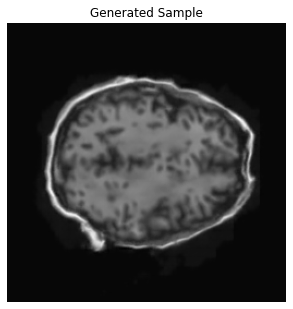

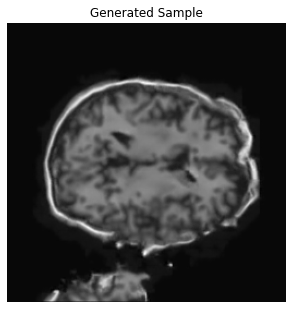

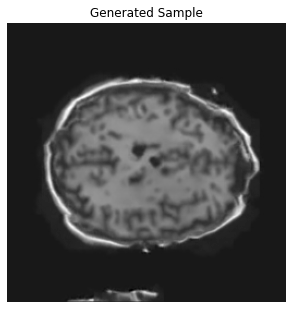

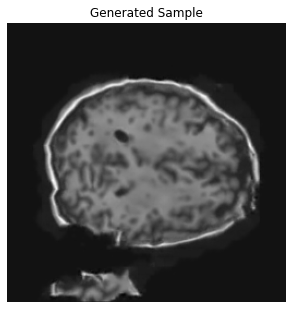

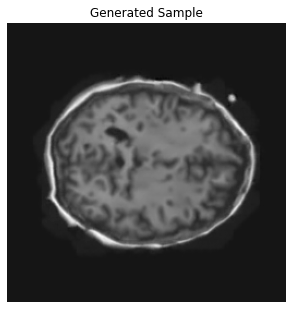

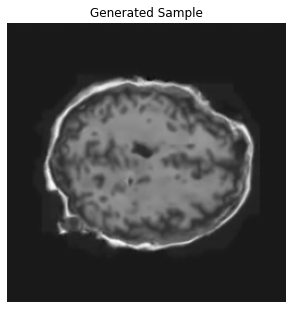

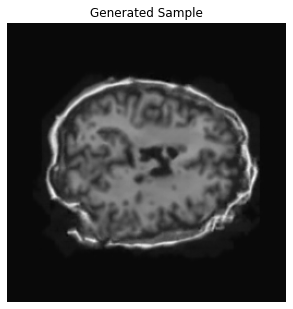

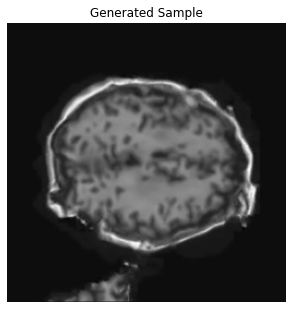

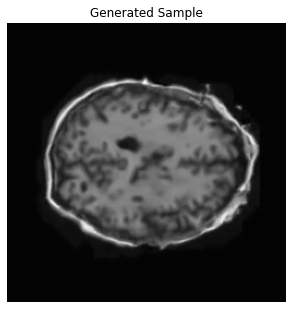

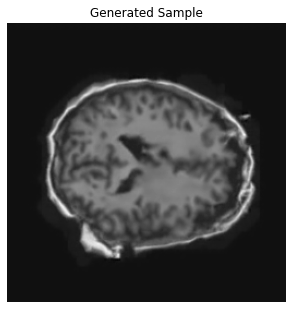

In [28]:
import matplotlib.pyplot as plt
from PIL import Image
# Generate novel images.
decoder = vqvae_trainer.decoder
generated_samples = decoder.predict(quantized)
figs = ['fig11.png','fig21.png','fig31.png','fig41.png','fig51.png','fig61.png','fig71.png','fig81.png','fig91.png','fig101.png']
for i in range(batch):
    #plt.subplot(1, 2, 2)
    plt.figure(figsize = (5,6))
    plt.imshow(generated_samples[i],cmap = 'gray')
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()
    im = keras.utils.array_to_img(generated_samples[i])
    im.save(figs[i])
    #PIL.Image.save(figs[i])